#Load Data from Kaggle

In [ ]:
#!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d validmodel/indo-fashion-dataset

100% 2.69G/2.69G [00:32<00:00, 126MB/s]
100% 2.69G/2.69G [00:32<00:00, 90.0MB/s]


In [ ]:
!unzip indo-fashion-dataset.zip > /dev/null

#Dataset Pruning

In [ ]:
import json

classLabels = set()

with open('/content/val_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    classLabels.add(sample.get('class_label'))

In [ ]:
classLabels

In [ ]:
import json

selected_samples=[]
counts={'gowns':0,
 'kurta_men':0,
 'lehenga':0,
 'nehru_jackets':0,
 'palazzos':0,
 'saree':0,
 'sherwanis':0,
 'women_kurta':0}
with open('/content/train_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    #print(sample['class_label'])
    #break
    if(sample['class_label'] not in ['blouse','leggings_and_salwars','mojaris_men','mojaris_women','dhoti_pants','petticoats', 'dupattas']):
      label = sample.get('class_label')
      if(counts[label]<200):
        selected_samples.append(sample)
        counts[label]=counts[label]+1

In [ ]:
n_samples=len(selected_samples)
print(f"No. of samples after pruning - {n_samples}")
print("Distribution of samples: \n")
print(counts)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,4))
plt.bar(counts.keys(), counts.values(), alpha=1)
plt.show()

In [ ]:
selected_samples[0]

In [ ]:
import pandas as pd
train_df = pd.DataFrame(selected_samples)

In [ ]:
train_df.head()

In [ ]:
train_df.drop(columns=['brand', 'product_title', 'color'], inplace=True)
train_df.head()

In [ ]:
train_df.to_csv("pruned_train_data.csv", index=False)

In [ ]:
test_selected_samples=[]
test_counts={'gowns':0,
 'kurta_men':0,
 'lehenga':0,
 'nehru_jackets':0,
 'palazzos':0,
 'saree':0,
 'sherwanis':0,
 'women_kurta':0}

with open('/content/test_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    if(sample['class_label'] not in ['blouse','leggings_and_salwars','mojaris_men','mojaris_women','dhoti_pants','petticoats', 'dupattas']):
      label = sample.get('class_label')
      test_selected_samples.append(sample)
      test_counts[label]=test_counts[label]+1

In [ ]:
n_test_samples=len(test_selected_samples)
print(f"No. of test samples after pruning - {n_test_samples}")
print("Distribution of test samples: \n")
print(test_counts)

In [ ]:
test_df = pd.DataFrame(test_selected_samples)
test_df.drop(columns=['brand', 'product_title', 'color'], inplace=True)
test_df.head()

In [ ]:
test_df.to_csv("pruned_test_data.csv",index=False)

In [ ]:
val_selected_samples=[]
val_counts={'gowns':0,
 'kurta_men':0,
 'lehenga':0,
 'nehru_jackets':0,
 'palazzos':0,
 'saree':0,
 'sherwanis':0,
 'women_kurta':0}

with open('/content/val_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    if(sample['class_label'] not in ['blouse','leggings_and_salwars','mojaris_men','mojaris_women','dhoti_pants','petticoats', 'dupattas']):
      label = sample.get('class_label')
      val_selected_samples.append(sample)
      val_counts[label]=val_counts[label]+1

In [ ]:
n_val_samples=len(val_selected_samples)
print(f"No. of valiadation samples after pruning - {n_val_samples}")
print("Distribution of validation samples: \n")
print(val_counts)

In [ ]:
val_df = pd.DataFrame(val_selected_samples)
val_df.drop(columns=['brand', 'product_title', 'color'], inplace=True)
val_df.head()

In [ ]:
val_df.to_csv("pruned_val_data.csv",index=False)

#Dataset Loading

In [ ]:
import pandas as pd
training_data = pd.read_csv('/content/pruned_train_data.csv')
training_data.head()

,image_url,image_path,class_label
0,https://m.media-amazon.com/images/I/81XKaSKvly...,images/train/0.jpeg,saree
1,https://m.media-amazon.com/images/I/91dDMDg+QT...,images/train/1.jpeg,saree
2,https://m.media-amazon.com/images/I/71TJ9p46PV...,images/train/2.jpeg,saree
3,https://m.media-amazon.com/images/I/81Y+je7CEg...,images/train/3.jpeg,saree
4,https://m.media-amazon.com/images/I/61B8o9Ulqp...,images/train/4.jpeg,saree


In [ ]:
training_data.shape

(20000, 3)

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class FashionDataset(Dataset):
    def __init__(self, dataframe, label_map, transform=None):
        self.data = dataframe
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = Image.open(img_path)
        label = self.label_map[(self.data.iloc[idx, 2])]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import DataLoader

label_map = {'gowns': 0, 'kurta_men': 1, 'lehenga': 2, 'nehru_jackets': 3,
             'palazzos': 4, 'saree': 5, 'sherwanis': 6, 'women_kurta': 7}

train_data = FashionDataset(dataframe = training_data, label_map = label_map, transform = transform)
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)

In [ ]:
validation_data = pd.read_csv('/content/pruned_val_data.csv')

val_data = FashionDataset(dataframe = validation_data, label_map = label_map, transform = transform)
val_dataloader = DataLoader(val_data, batch_size = 64, shuffle = True)

In [ ]:
testing_data = pd.read_csv('/content/pruned_test_data.csv')

test_data = FashionDataset(dataframe = testing_data, label_map = label_map, transform = transform)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

#VGG-16

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using "+str(device))

vgg16 = models.vgg16(weights=None)
vgg16.classifier[-1] = nn.Linear(4096, 8) # 8 output classes
vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Using cuda


In [ ]:
import torch
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):

    vgg16.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):

        inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation

    vgg16.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_dataloader):

            inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(val_dataloader)}], Val Loss: {loss.item():.4f}')

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

print('Training complete')

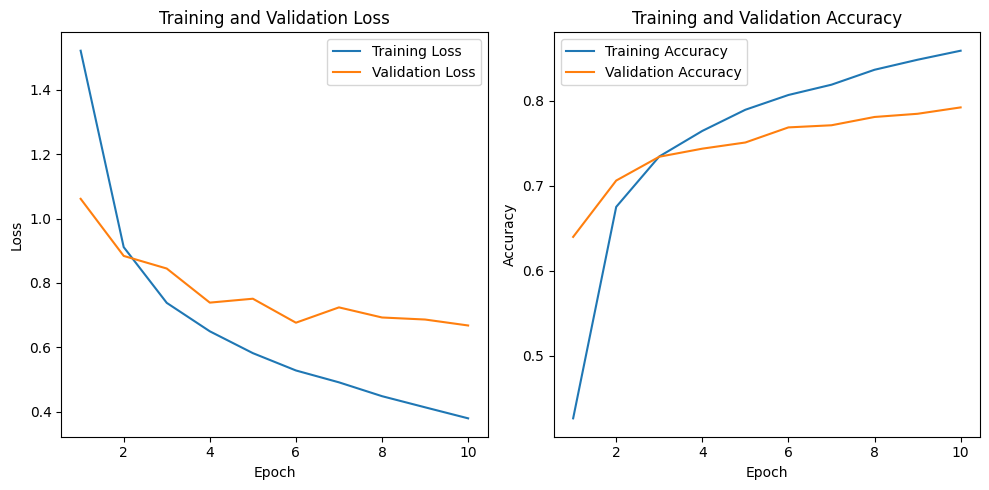

In [ ]:
import matplotlib.pyplot as plt

# training and validation loss

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Testing Accuracy: 80.22500000000001
Testing Loss: 0.6434868984222412
F1 Score: 0.801520158983283


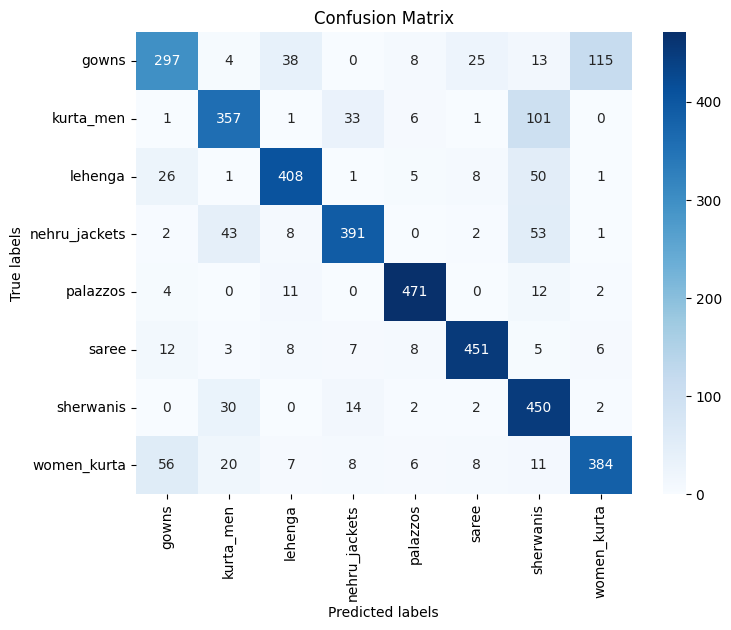

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

accuracy_history = []
loss_history = []

def test_model(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            accuracy = correct / total
            loss_history.append(loss.item())
            accuracy_history.append(accuracy)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = (correct / total)*100
    test_loss = test_loss / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)

    return test_accuracy, test_loss, f1, cm

test_accuracy, test_loss, f1, confusion_matrix = test_model(vgg16, test_dataloader, criterion, device)

print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')
print(f'F1 Score: {f1}')

# conf matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

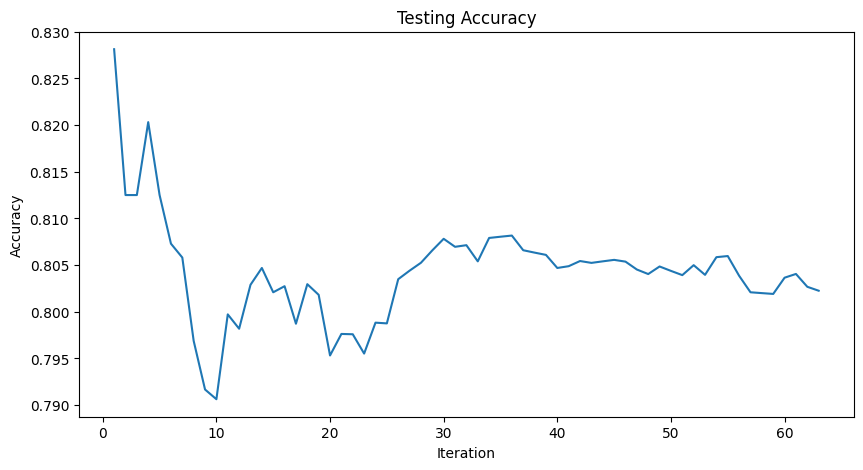

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')
plt.show()

In [ ]:
torch.save(vgg16, '/content/vgg16.pt')

# ResNet18

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using "+str(device))

resnet18 = models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 8) # 8 output classes
resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

Using cuda


In [ ]:
import torch
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):

    resnet18.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):

        inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation

    resnet18.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_dataloader):

            inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(val_dataloader)}], Val Loss: {loss.item():.4f}')

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

print('Training complete')

Epoch [1/10], Batch [1/313], Train Loss: 2.1387
Epoch [1/10], Batch [2/313], Train Loss: 2.1096
Epoch [1/10], Batch [3/313], Train Loss: 2.1270
Epoch [1/10], Batch [4/313], Train Loss: 2.1223
Epoch [1/10], Batch [5/313], Train Loss: 2.1464
Epoch [1/10], Batch [6/313], Train Loss: 2.0377
Epoch [1/10], Batch [7/313], Train Loss: 2.0669
Epoch [1/10], Batch [8/313], Train Loss: 2.0890
Epoch [1/10], Batch [9/313], Train Loss: 2.0660
Epoch [1/10], Batch [10/313], Train Loss: 2.0451
Epoch [1/10], Batch [11/313], Train Loss: 2.0766
Epoch [1/10], Batch [12/313], Train Loss: 2.0649
Epoch [1/10], Batch [13/313], Train Loss: 2.0336
Epoch [1/10], Batch [14/313], Train Loss: 2.0395
Epoch [1/10], Batch [15/313], Train Loss: 2.0197
Epoch [1/10], Batch [16/313], Train Loss: 2.0490
Epoch [1/10], Batch [17/313], Train Loss: 2.1159
Epoch [1/10], Batch [18/313], Train Loss: 1.9727
Epoch [1/10], Batch [19/313], Train Loss: 1.9783
Epoch [1/10], Batch [20/313], Train Loss: 1.9820
Epoch [1/10], Batch [21/313],

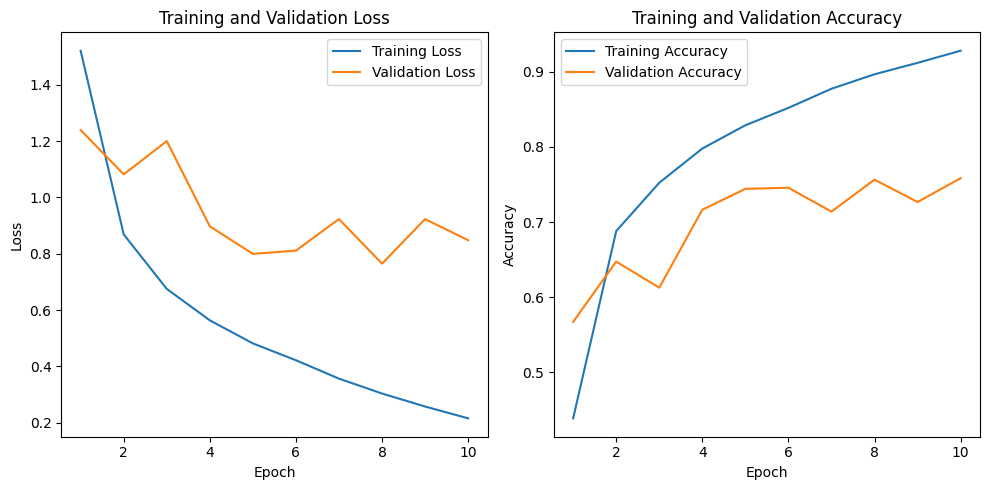

In [ ]:
import matplotlib.pyplot as plt

# training and validation loss

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Testing Accuracy: 76.5
Testing Loss: 0.836399863243103
F1 Score: 0.7610458968651217


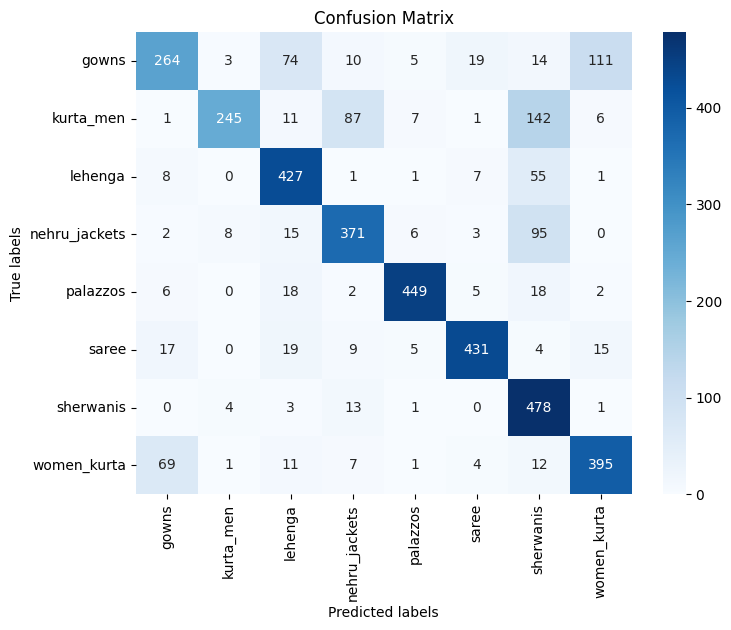

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

accuracy_history = []
loss_history = []

def test_model(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            accuracy = correct / total
            loss_history.append(loss.item())
            accuracy_history.append(accuracy)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = (correct / total)*100
    test_loss = test_loss / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)

    return test_accuracy, test_loss, f1, cm

test_accuracy, test_loss, f1, confusion_matrix = test_model(resnet18, test_dataloader, criterion, device)

print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')
print(f'F1 Score: {f1}')

# conf matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

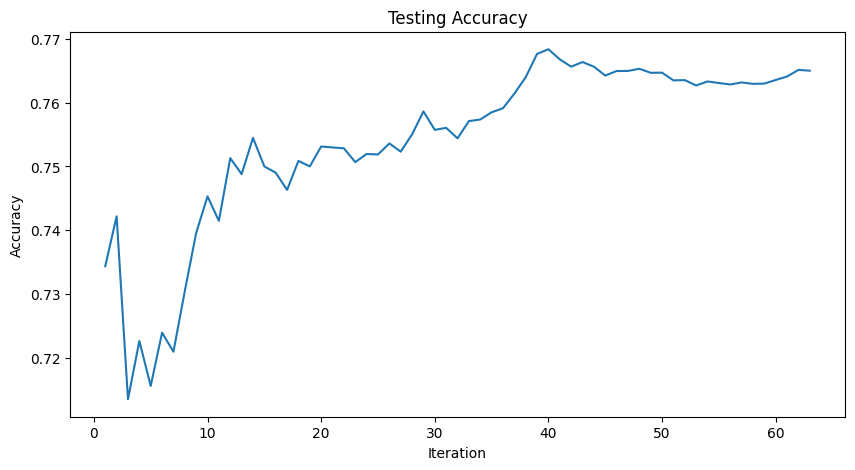

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')
plt.show()

In [ ]:
torch.save(resnet18, '/content/resnet18.pt')

# MobilenetV2

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using "+str(device))

mobilenet = models.mobilenet_v2(weights=None)
mobilenet.classifier[-1] = nn.Linear(1280, 8) # 8 output classes
mobilenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobilenet.parameters(), lr=0.001, momentum=0.9)

Using cuda


In [ ]:
import torch
import numpy as np

mb_train_losses = []
mb_val_losses = []
mb_train_accuracies = []
mb_val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):

    mobilenet.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):

        inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

        optimizer.zero_grad()
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader.dataset)
    train_accuracy = correct_train / total_train
    mb_train_losses.append(train_loss)
    mb_train_accuracies.append(train_accuracy)

    # Validation

    mobilenet.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_dataloader):

            inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

            outputs = mobilenet(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(val_dataloader)}], Val Loss: {loss.item():.4f}')

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / total_val
    mb_val_losses.append(val_loss)
    mb_val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

print('Training complete')

Epoch [1/10], Batch [1/313], Train Loss: 2.1269
Epoch [1/10], Batch [2/313], Train Loss: 2.0912
Epoch [1/10], Batch [3/313], Train Loss: 2.0871
Epoch [1/10], Batch [4/313], Train Loss: 2.1221
Epoch [1/10], Batch [5/313], Train Loss: 2.0617
Epoch [1/10], Batch [6/313], Train Loss: 2.0697
Epoch [1/10], Batch [7/313], Train Loss: 2.0614
Epoch [1/10], Batch [8/313], Train Loss: 2.0955
Epoch [1/10], Batch [9/313], Train Loss: 2.0861
Epoch [1/10], Batch [10/313], Train Loss: 2.1159
Epoch [1/10], Batch [11/313], Train Loss: 2.0547
Epoch [1/10], Batch [12/313], Train Loss: 2.0891
Epoch [1/10], Batch [13/313], Train Loss: 2.0530
Epoch [1/10], Batch [14/313], Train Loss: 2.0819
Epoch [1/10], Batch [15/313], Train Loss: 2.0375
Epoch [1/10], Batch [16/313], Train Loss: 2.0643
Epoch [1/10], Batch [17/313], Train Loss: 2.0335
Epoch [1/10], Batch [18/313], Train Loss: 2.0892
Epoch [1/10], Batch [19/313], Train Loss: 2.0875
Epoch [1/10], Batch [20/313], Train Loss: 2.0504
Epoch [1/10], Batch [21/313],

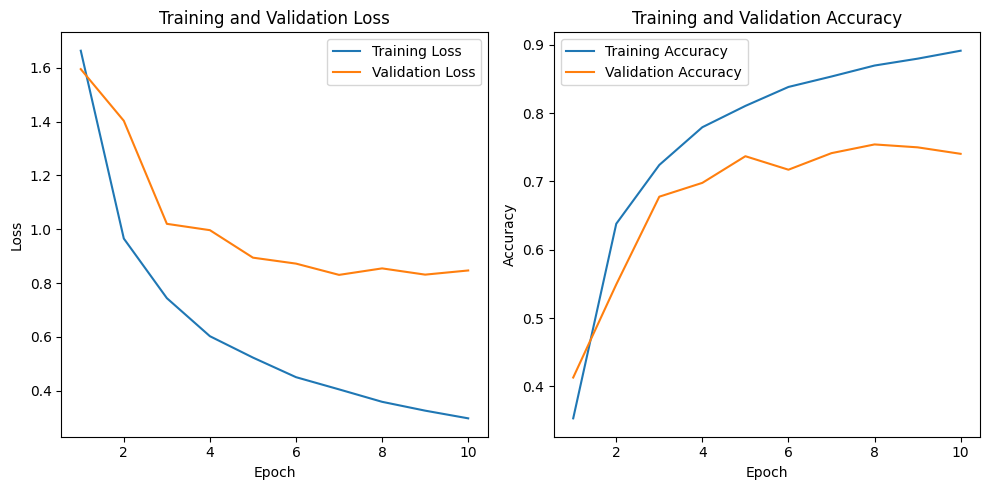

In [ ]:
import matplotlib.pyplot as plt

# training and validation loss

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), mb_train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), mb_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), mb_train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), mb_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Testing Accuracy: 74.675
Testing Loss: 0.8344364275932312
F1 Score: 0.7492545618449644


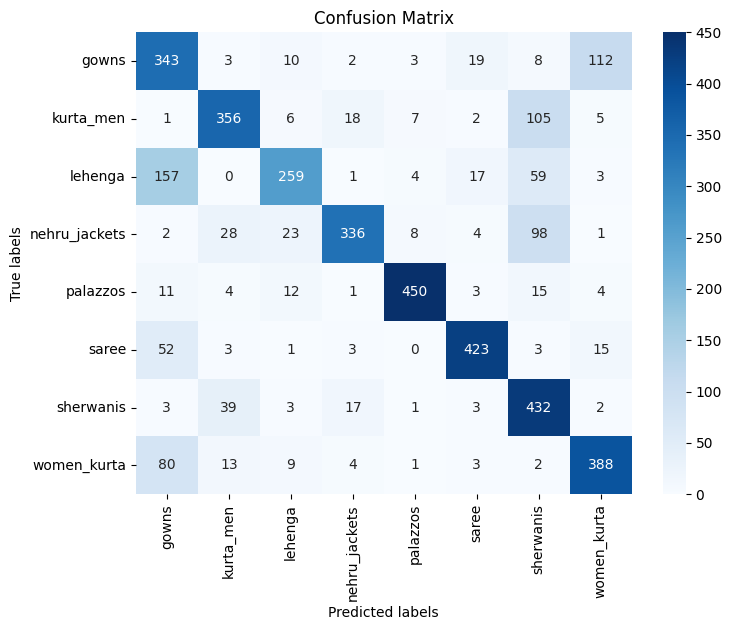

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

mb_accuracy_history = []
mb_loss_history = []

def test_model(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            accuracy = correct / total
            mb_loss_history.append(loss.item())
            mb_accuracy_history.append(accuracy)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = (correct / total)*100
    test_loss = test_loss / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)

    return test_accuracy, test_loss, f1, cm

test_accuracy, test_loss, f1, confusion_matrix = test_model(mobilenet, test_dataloader, criterion, device)

print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')
print(f'F1 Score: {f1}')

# conf matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

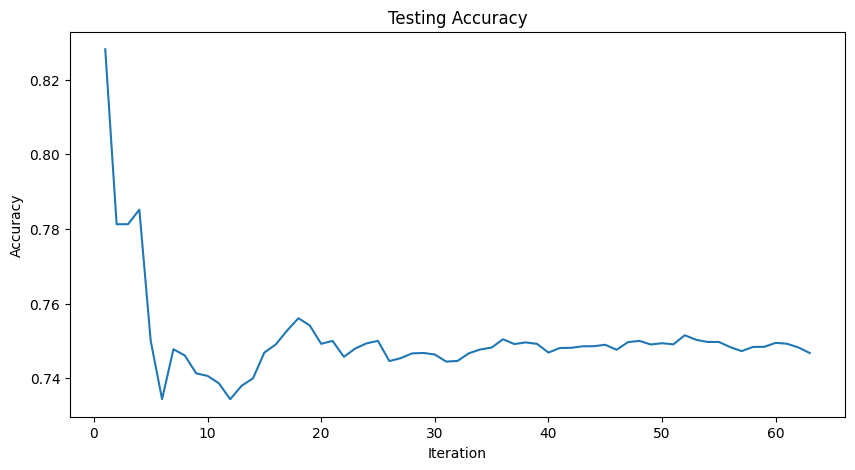

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(mb_accuracy_history) + 1), mb_accuracy_history)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')
plt.show()

In [ ]:
torch.save(mobilenet, '/content/mobilenet.pt')

# Plots

In [ ]:
import torch
import numpy as np

def test_model(model, test_loader, criterion, device):

  accuracy_history = []
  loss_history = []
  model.eval()

  test_loss = 0.0
  correct = 0
  total = 0
  all_predictions = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          test_loss += loss.item() * inputs.size(0)

          _, predicted = torch.max(outputs, 1)
          correct += (predicted == labels).sum().item()
          total += labels.size(0)

          accuracy = correct / total
          loss_history.append(loss.item())
          accuracy_history.append(accuracy)

          all_predictions.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  test_accuracy = (correct / total)*100
  print(str(model)+"test accuracy: "+str(test_accuracy)+"%")

  return accuracy_history, loss_history

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using "+str(device))

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

vgg16 = torch.load('/content/vgg16.pt')
vgg16.to(device)

resnet18 = torch.load('/content/resnet18.pt')
resnet18.to(device)

mobilenet = torch.load('/content/mobilenet.pt')
mobilenet.to(device)

In [ ]:
vgg_accuracies, vgg_losses = test_model(vgg16, test_dataloader, criterion, device)
rn18_accuracies, rn18_losses = test_model(resnet18, test_dataloader, criterion, device)
mbnet_accuracies, mbnet_losses = test_model(mobilenet, test_dataloader, criterion, device)

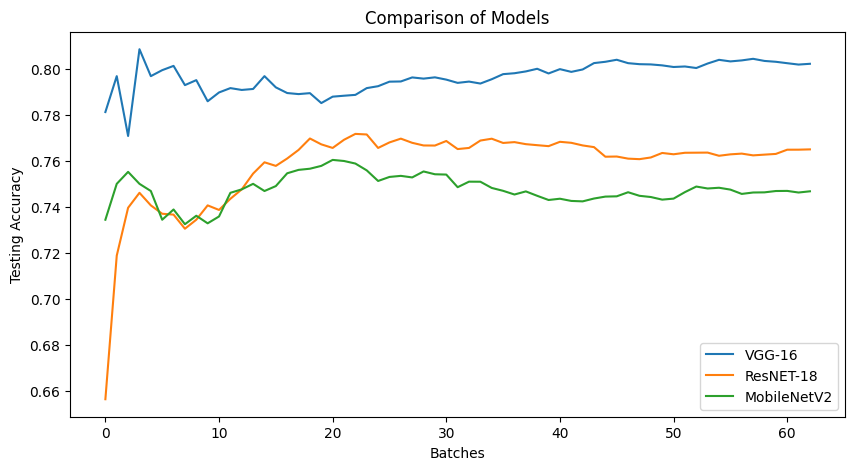

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(vgg_accuracies)), vgg_accuracies, label='VGG-16')
plt.plot(range(len(rn18_accuracies)), rn18_accuracies, label='ResNET-18')
plt.plot(range(len(mbnet_accuracies)), mbnet_accuracies, label='MobileNetV2')
plt.xlabel('Batches')
plt.ylabel('Testing Accuracy')
plt.title('Comparison of Models')
plt.legend()

#ResNet18 Transfer Learning

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using "+str(device))

resnet18 = models.resnet18(weights='IMAGENET1K_V1')
resnet18.fc = nn.Linear(resnet18.fc.in_features, 8) # 8 output classes
resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

Using cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.6MB/s]


In [ ]:
import torch
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):

    resnet18.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):

        inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation

    resnet18.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_dataloader):

            inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(val_dataloader)}], Val Loss: {loss.item():.4f}')

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

print('Training complete')

Epoch [1/10], Batch [1/313], Train Loss: 1.9097
Epoch [1/10], Batch [2/313], Train Loss: 2.1089
Epoch [1/10], Batch [3/313], Train Loss: 2.1163
Epoch [1/10], Batch [4/313], Train Loss: 2.1944
Epoch [1/10], Batch [5/313], Train Loss: 2.1684
Epoch [1/10], Batch [6/313], Train Loss: 1.9819
Epoch [1/10], Batch [7/313], Train Loss: 1.8587
Epoch [1/10], Batch [8/313], Train Loss: 1.9101
Epoch [1/10], Batch [9/313], Train Loss: 1.8629
Epoch [1/10], Batch [10/313], Train Loss: 1.9070
Epoch [1/10], Batch [11/313], Train Loss: 1.8777
Epoch [1/10], Batch [12/313], Train Loss: 1.7684
Epoch [1/10], Batch [13/313], Train Loss: 1.8275
Epoch [1/10], Batch [14/313], Train Loss: 1.7562
Epoch [1/10], Batch [15/313], Train Loss: 1.7598
Epoch [1/10], Batch [16/313], Train Loss: 1.6638
Epoch [1/10], Batch [17/313], Train Loss: 1.5061
Epoch [1/10], Batch [18/313], Train Loss: 1.6485
Epoch [1/10], Batch [19/313], Train Loss: 1.4902
Epoch [1/10], Batch [20/313], Train Loss: 1.5023
Epoch [1/10], Batch [21/313],

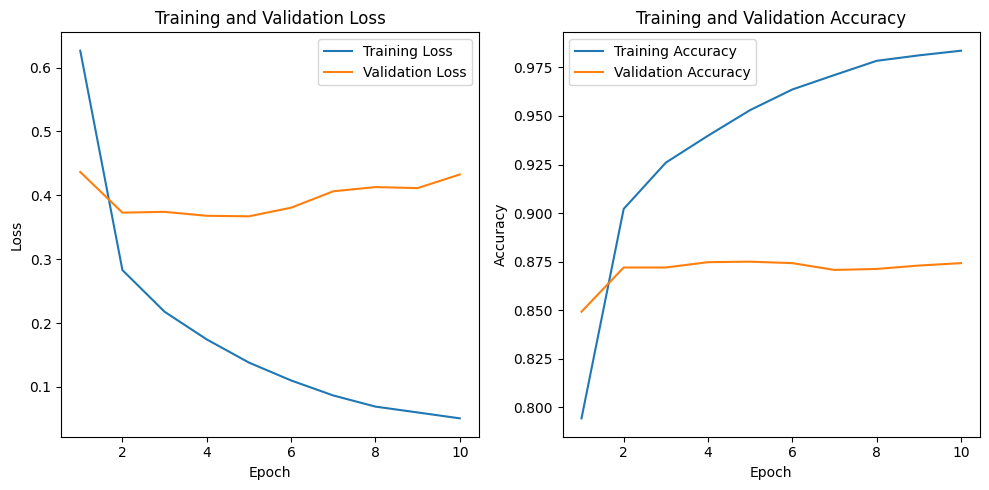

In [ ]:
import matplotlib.pyplot as plt

# training and validation loss

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Testing Accuracy: 88.075
Testing Loss: 0.44527885723114013
F1 Score: 0.8790318916775229


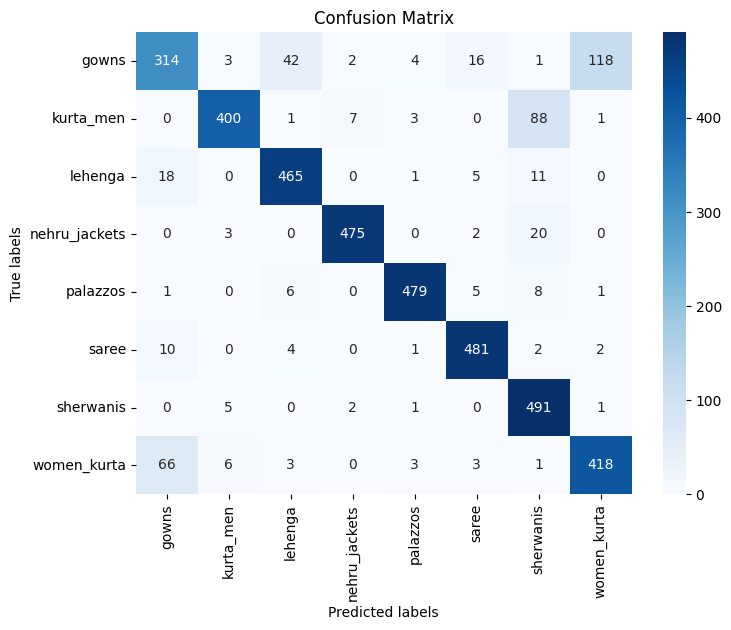

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

accuracy_history = []
loss_history = []

def test_model(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            accuracy = correct / total
            loss_history.append(loss.item())
            accuracy_history.append(accuracy)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = (correct / total)*100
    test_loss = test_loss / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)

    return test_accuracy, test_loss, f1, cm

test_accuracy, test_loss, f1, confusion_matrix = test_model(resnet18, test_dataloader, criterion, device)

print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')
print(f'F1 Score: {f1}')

# conf matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

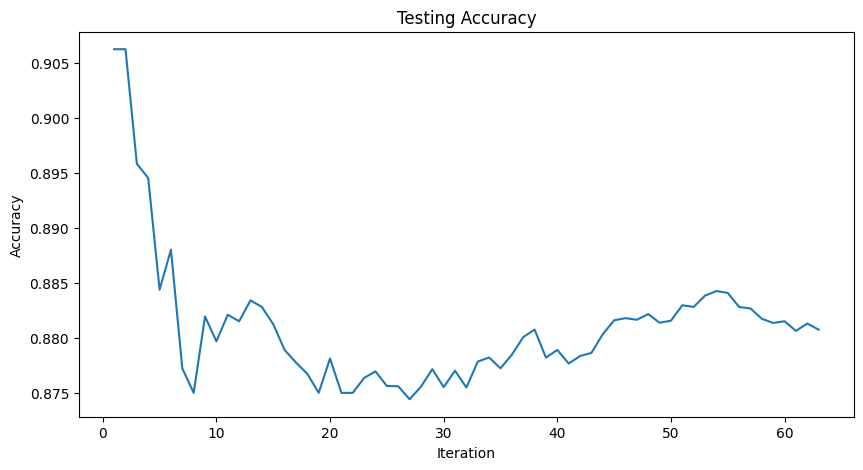

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')
plt.show()

In [ ]:
torch.save(resnet18, '/content/resnet18tl.pt')

#VGG-16 Hyper Parameter Tuning

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using "+str(device))

def vgg_net_16():

  vgg16 = models.vgg16(weights=None)
  vgg16.classifier[-1] = nn.Linear(4096, 8)

  return vgg16

Using cuda


In [ ]:
import torch
import numpy as np

def train(learning_rate):

  train_losses = []
  train_accuracies = []

  model = vgg_net_16()
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

  num_epochs = 5

  for epoch in range(num_epochs):

      train_loss = 0.0
      correct_train = 0
      total_train = 0

      for batch_idx, (inputs, labels) in enumerate(train_dataloader):

          inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          train_loss += loss.item() * inputs.size(0)
          _, predicted = torch.max(outputs, 1)
          correct_train += (predicted == labels).sum().item()
          total_train += labels.size(0)

      train_loss /= len(train_dataloader.dataset)
      train_accuracy = correct_train / total_train
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}')

  return train_losses, train_accuracies
  print('Training complete')

In [ ]:
train_loss_hyper_paramaters = {}
train_acc_hyper_paramaters = {}

hyper_parameters= {"learning_rate":[0.01,0.001,0.0001]}

for learning_rate in hyper_parameters["learning_rate"]:

    print(f'Results of the learning rate = {learning_rate}')
    train_loss, train_accuracy = train(learning_rate)

    train_loss_hyper_paramaters[f"lr{learning_rate}"] = train_loss
    train_acc_hyper_paramaters[f"lr{learning_rate}"] = train_accuracy

Results of the learning rate = 0.01
Epoch [1/5], Train Loss: 1.3132, Train Acc: 0.5122
Epoch [2/5], Train Loss: 0.6389, Train Acc: 0.7678
Epoch [3/5], Train Loss: 0.5017, Train Acc: 0.8176
Epoch [4/5], Train Loss: 0.4179, Train Acc: 0.8469
Epoch [5/5], Train Loss: 0.3534, Train Acc: 0.8679
Results of the learning rate = 0.001
Epoch [1/5], Train Loss: 1.6392, Train Acc: 0.3740
Epoch [2/5], Train Loss: 0.9231, Train Acc: 0.6738
Epoch [3/5], Train Loss: 0.7310, Train Acc: 0.7383
Epoch [4/5], Train Loss: 0.6196, Train Acc: 0.7754
Epoch [5/5], Train Loss: 0.5577, Train Acc: 0.7962
Results of the learning rate = 0.0001
Epoch [1/5], Train Loss: 2.0736, Train Acc: 0.1419
Epoch [2/5], Train Loss: 2.0438, Train Acc: 0.1877
Epoch [3/5], Train Loss: 1.8360, Train Acc: 0.3233
Epoch [4/5], Train Loss: 1.3613, Train Acc: 0.5101
Epoch [5/5], Train Loss: 1.1234, Train Acc: 0.6052


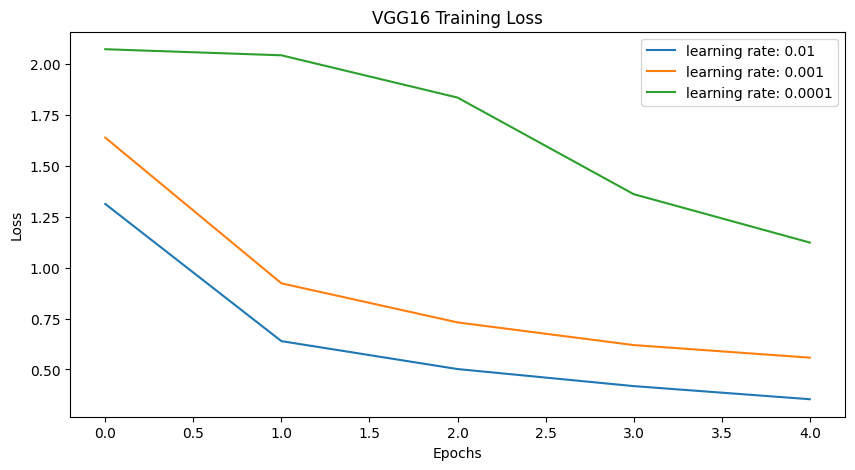

In [ ]:
import matplotlib.pyplot as plt
epochs = [i for i in range(5)]
plt.figure(figsize=(10,5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16 Training Loss')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,train_loss_hyper_paramaters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')

plt.legend()

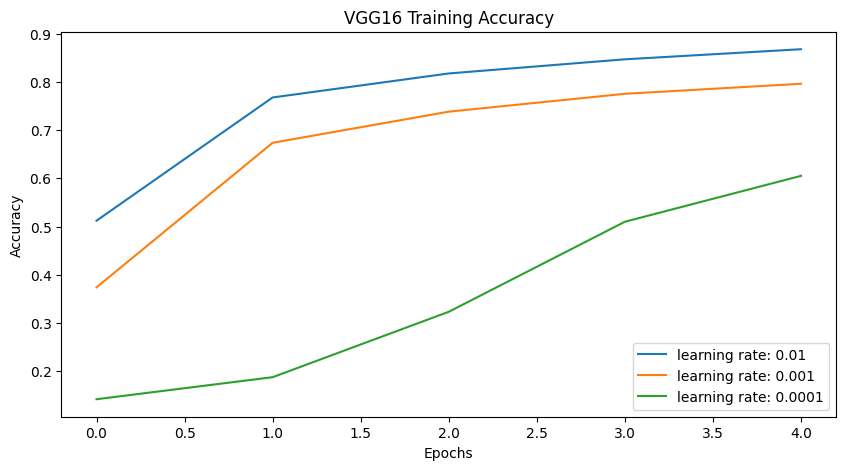

In [ ]:
epochs = [i for i in range(5)]
plt.figure(figsize=(10,5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16 Training Accuracy')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,train_acc_hyper_paramaters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')

plt.legend()

#VGG-16 - Optimal Hyper Parameter (lr=0.01)

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using "+str(device))

vgg16 = models.vgg16(weights=None)
vgg16.classifier[-1] = nn.Linear(4096, 8) # 8 output classes
vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

Using cuda


In [ ]:
import torch
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):

    vgg16.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):

        inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation

    vgg16.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_dataloader):

            inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(val_dataloader)}], Val Loss: {loss.item():.4f}')

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

print('Training complete')

Epoch [1/10], Batch [1/313], Train Loss: 2.0922
Epoch [1/10], Batch [2/313], Train Loss: 2.0827
Epoch [1/10], Batch [3/313], Train Loss: 2.0893
Epoch [1/10], Batch [4/313], Train Loss: 2.0826
Epoch [1/10], Batch [5/313], Train Loss: 2.0940
Epoch [1/10], Batch [6/313], Train Loss: 2.1123
Epoch [1/10], Batch [7/313], Train Loss: 2.0928
Epoch [1/10], Batch [8/313], Train Loss: 2.0607
Epoch [1/10], Batch [9/313], Train Loss: 2.0774
Epoch [1/10], Batch [10/313], Train Loss: 2.0599
Epoch [1/10], Batch [11/313], Train Loss: 2.0782
Epoch [1/10], Batch [12/313], Train Loss: 2.0757
Epoch [1/10], Batch [13/313], Train Loss: 2.0870
Epoch [1/10], Batch [14/313], Train Loss: 2.0280
Epoch [1/10], Batch [15/313], Train Loss: 2.0758
Epoch [1/10], Batch [16/313], Train Loss: 2.0594
Epoch [1/10], Batch [17/313], Train Loss: 2.0925
Epoch [1/10], Batch [18/313], Train Loss: 2.1009
Epoch [1/10], Batch [19/313], Train Loss: 2.1006
Epoch [1/10], Batch [20/313], Train Loss: 2.0648
Epoch [1/10], Batch [21/313],

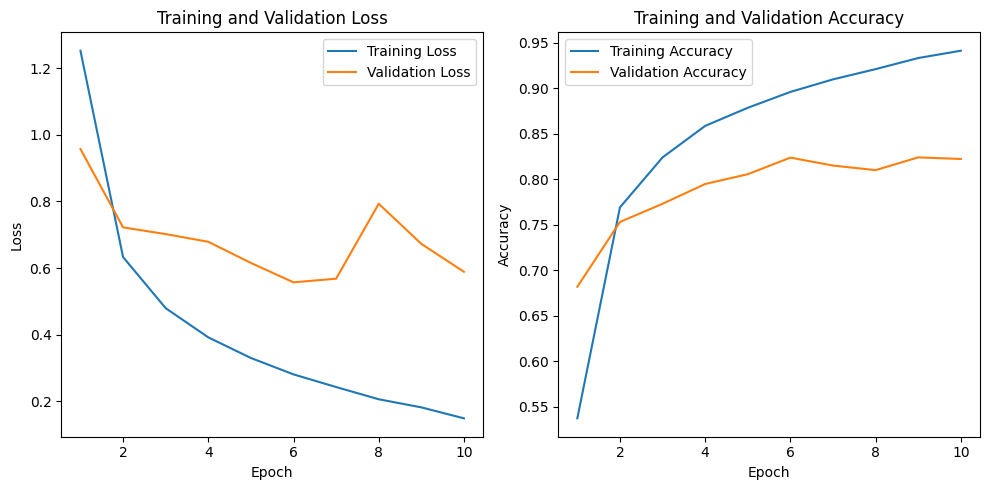

In [ ]:
import matplotlib.pyplot as plt

# training and validation loss

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Testing Accuracy: 83.2
Testing Loss: 0.5692647575736046
F1 Score: 0.8320595404058156


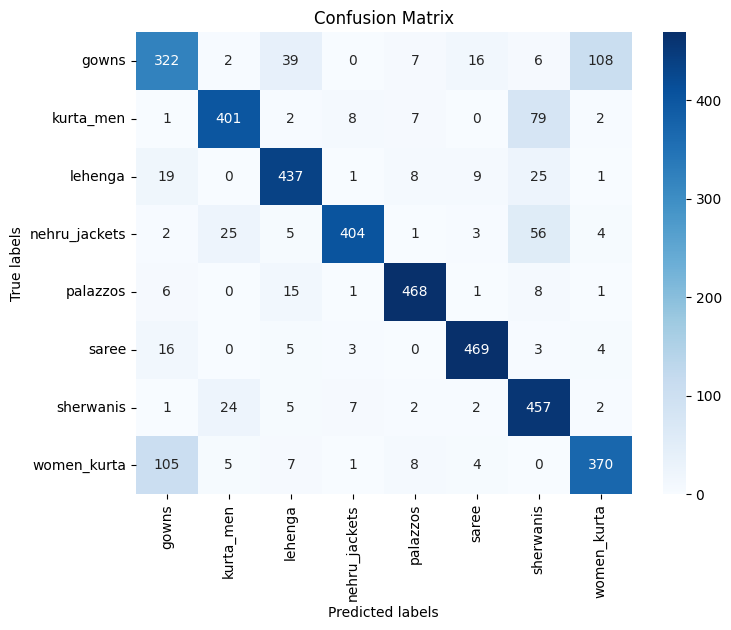

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

accuracy_history = []
loss_history = []

def test_model(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            accuracy = correct / total
            loss_history.append(loss.item())
            accuracy_history.append(accuracy)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = (correct / total)*100
    test_loss = test_loss / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)

    return test_accuracy, test_loss, f1, cm

test_accuracy, test_loss, f1, confusion_matrix = test_model(vgg16, test_dataloader, criterion, device)

print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')
print(f'F1 Score: {f1}')

# conf matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

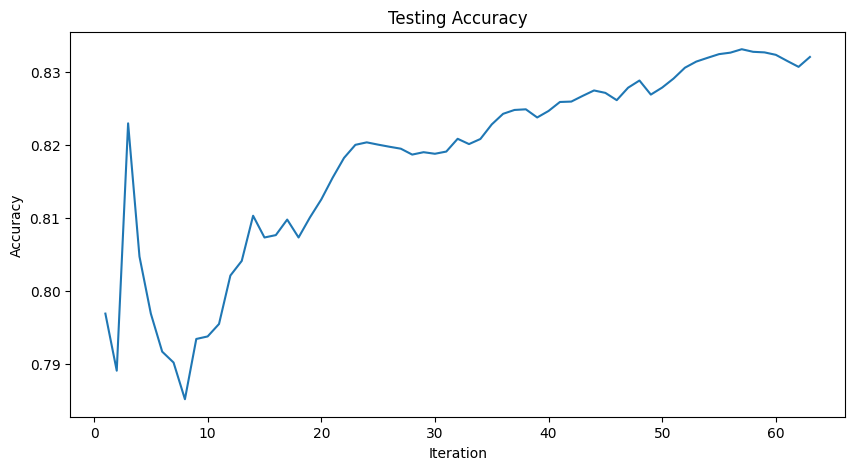

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')
plt.show()

In [ ]:
torch.save(vgg16, '/content/vgg16hpt.pt')

# t-SNE Plot

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, dataframe, label_map, transform=None):
        self.data = dataframe
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = Image.open(img_path)
        label = self.label_map[(self.data.iloc[idx, 2])]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((24, 24)),
    transforms.ToTensor(),
])

In [ ]:
label_map = {'gowns': 0, 'kurta_men': 1, 'lehenga': 2, 'nehru_jackets': 3,
             'palazzos': 4, 'saree': 5, 'sherwanis': 6, 'women_kurta': 7}

testset = pd.read_csv('/content/pruned_train_data.csv')

testset_data = CustomDataset(dataframe = testset, label_map = label_map, transform = transform)

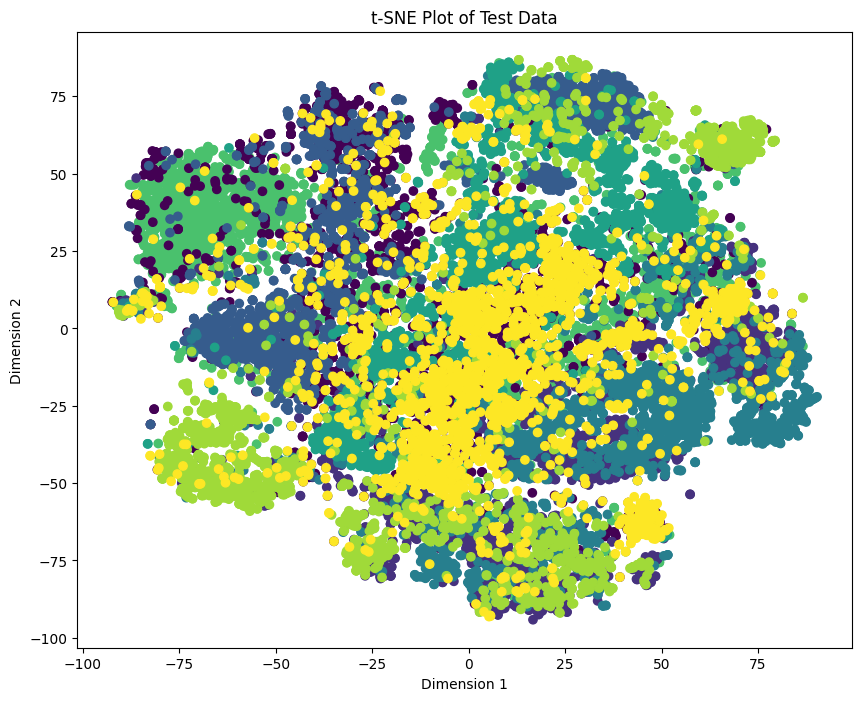

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

features = []
labels = []

for sample in testset_data:
    features.append(sample[0].flatten())
    labels.append(sample[1])

features = np.array(features)

tsne_results = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=30).fit_transform(features)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels)
plt.title('t-SNE Plot of Test Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using "+str(device))

vggnet = torch.load('/content/vgg16.pt')
vggnet.to(device)
print('VGG16 loaded')

resnet = torch.load('/content/resnet18.pt')
resnet.to(device)
print('ResNet18 loaded')

mobilenet = torch.load('/content/mobilenet.pt')
mobilenet.to(device)
print('MobileNetV2 loaded')

resnettl = torch.load('/content/resnet18tl.pt')
resnettl.to(device)
print('ResNet18-TL loaded')

Using cuda
VGG16 loaded
ResNet18 loaded
MobileNetV2 loaded
ResNet18-TL loaded
